# 1.3.2 Self-Normalized Inverse Propensity Score(SNIPS)推定量
参考文献
- Adith Swaminathan and Thorsten Joachims. [The Self-Normalized Estimator for Counterfactual Learning](https://papers.nips.cc/paper_files/paper/2015/hash/39027dfad5138c9ca0c474d71db915c3-Abstract.html). NeurIPS2015.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.utils import check_random_state
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.style.use('ggplot')
y_label_dict = {"se": "左図：平均二乗誤差", "bias": "中図：二乗バイアス", "variance": "右図：バリアンス"}

# import open bandit pipeline (obp)
import obp
from obp.dataset import (
    SyntheticBanditDatasetWithActionEmbeds as SyntheticBanditDataset,
    logistic_polynomial_reward_function,
)
from obp.ope import (
    OffPolicyEvaluation,
    RegressionModel,
    InverseProbabilityWeighting as IPS,
    DoublyRobust as DR,
    SelfNormalizedInverseProbabilityWeighting as SNIPS,
)
from utils import eps_greedy_policy, aggregate_simulation_results

In [2]:
print(obp.__version__)


0.5.5


### (データ収集方策が収集した)ログデータのサイズ$n$を変化させたときのSNIPS推定量の平均二乗誤差・二乗バイアス・バリアンスの挙動

In [3]:
## シミュレーション設定
num_runs = 500 # シミュレーションの繰り返し回数
dim_context = 10 # 特徴量xの次元
n_actions = 100 # 行動数, |A|
beta = -5 # データ収集方策のパラメータ
random_state = 12345
test_data_size = 100000 # 評価方策の真の性能を近似するためのテストデータのサイズ
random_ = check_random_state(random_state)
num_data_list = [250, 500, 1000, 2000, 4000, 8000]


In [4]:
result_df_list = []
for num_data in num_data_list:
    ## 人工データ生成クラス
    dataset = SyntheticBanditDataset(
        n_actions=n_actions,
        dim_context=dim_context,
        action_context=random_.normal(size=(n_actions, 10)),
        beta=beta,
        reward_function=logistic_polynomial_reward_function,
        random_state=random_state,
    )

    ## 評価方策の真の性能(policy value)を近似するためのテストデータ
    test_data = dataset.obtain_batch_bandit_feedback(n_rounds=test_data_size)

    ## 評価方策の真の性能(policy value)を近似
    policy_value = dataset.calc_ground_truth_policy_value(
        expected_reward=test_data["expected_reward"],
        action_dist=eps_greedy_policy(test_data["expected_reward"]),
    )

    estimated_policy_value_list = []
    for _ in tqdm(range(num_runs), desc=f"num_data={num_data}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = dataset.obtain_batch_bandit_feedback(
            n_rounds=num_data
        )

        ## ログデータ上における評価方策の行動選択確率を計算
        pi = eps_greedy_policy(offline_logged_data["expected_reward"])

        ## 期待報酬関数に対する推定モデル\hat{q}(x,a)を得る
        reg_model = RegressionModel(
            n_actions=dataset.n_actions,
            base_model=MLPClassifier(
                hidden_layer_sizes=(10, 10), random_state=random_state
            ),
        )
        estimated_rewards_mlp = reg_model.fit_predict(
            context=offline_logged_data["context"], # context; x
            action=offline_logged_data["action"], # action; a
            reward=offline_logged_data["reward"], # reward; r
            random_state=random_state,
        )

        ## ログデータを用いてオフ方策評価を実行する
        ope = OffPolicyEvaluation(
            bandit_feedback=offline_logged_data,
            ope_estimators=[
                IPS(estimator_name="IPS"),
                DR(estimator_name="DR"),
                SNIPS(estimator_name="SNIPS"),
            ]
        )
        estimated_policy_values = ope.estimate_policy_values(
            action_dist=pi,
            estimated_rewards_by_reg_model=estimated_rewards_mlp,
        )
        estimated_policy_value_list.append(estimated_policy_values)

    ## シミュレーション結果を集計する
    result_df_list.append(
        aggregate_simulation_results(
            estimated_policy_value_list, policy_value, "num_data", num_data,
        )
    )
result_df = pd.concat(result_df_list).reset_index(level=0)


num_data=8000...: 100%|██████████| 500/500 [23:19<00:00,  2.80s/it]


## 図1.23

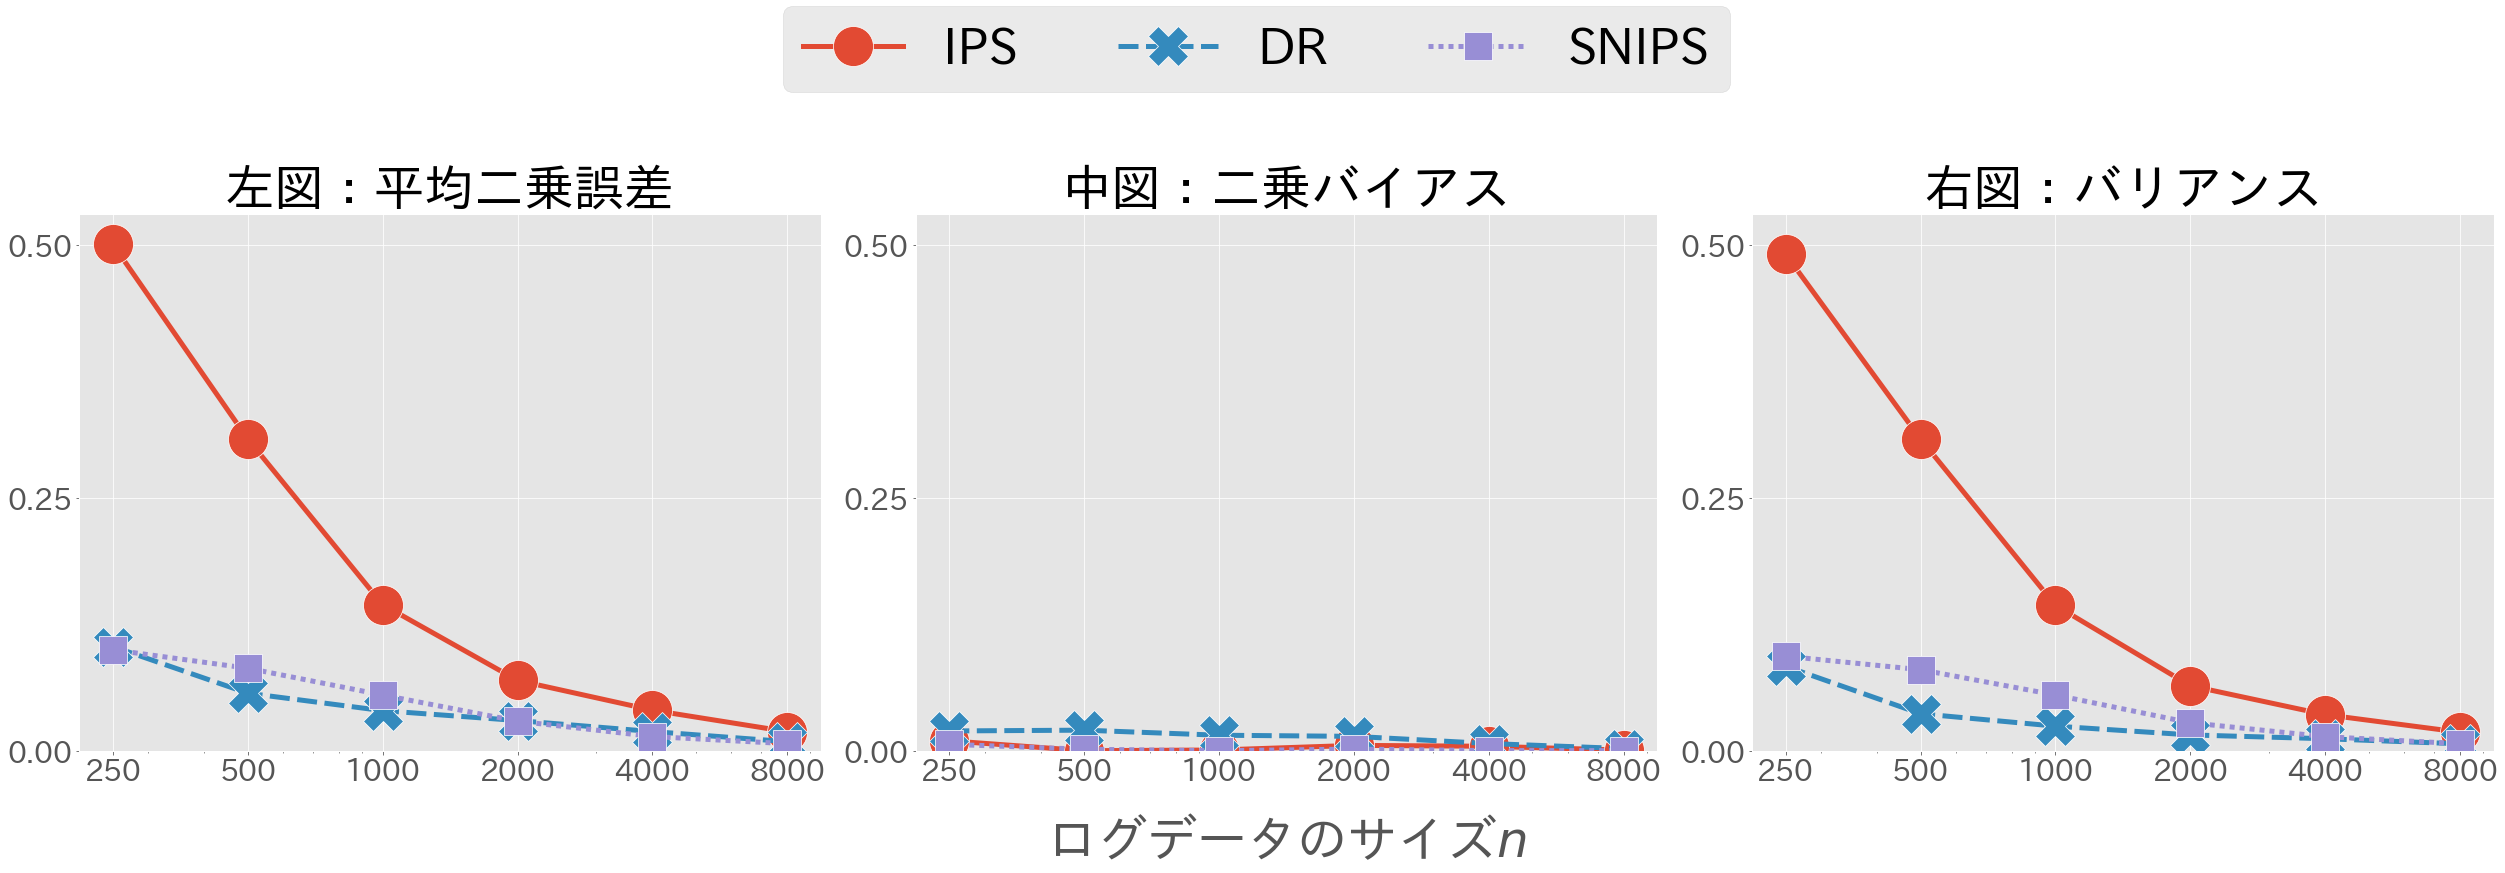

In [7]:
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=5,
        legend=False,
        style="est",
        x="num_data",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        data=result_df,
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 0.53)
    ax.tick_params(axis="y", labelsize=30)
    ax.set_yticks([0.0, 0.25, 0.5])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xscale("log")
    if i == 1:
        ax.set_xlabel(r"ログデータのサイズ$n$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(num_data_list)
    ax.set_xticklabels(num_data_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(
    ["IPS", "DR", "SNIPS"], fontsize=50, bbox_to_anchor=(0.5, 1.15), ncol=4, loc="center",
)
